# Initial value problem

In [1]:
from math import sin, cos, log, ceil
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
g = 9.8
v_t = 4.9
CLD = 5.0

v0 = v_t
theta0 = 0
x0 = 0
y0 = 10

In [3]:
def f(u):
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    return numpy.array([-g*sin(theta) - (1/CLD)*g/v_t**2*v**2,
                      -g*cos(theta)/v + g/v_t**2*v,
                      v*cos(theta),
                      v*sin(theta)])

In [4]:
def euler_step(u, f, dt):
    return u + dt * f(u)

In [5]:
T = 100
dt = 0.1
N = int(T/dt) + 1

u = numpy.empty((N, 4))
u[0] = numpy.array([v0, theta0, x0, y0])

for n in range(N-1):
    u[n+1] = euler_step(u[n], f, dt)

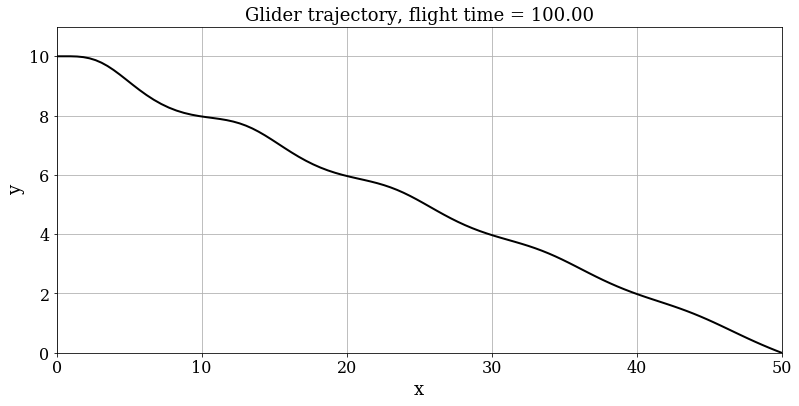

In [14]:
x = u[:,2]
y = u[:,3]

pyplot.figure(figsize=(13,6))
pyplot.grid(True)
pyplot.xlabel(r'x', fontsize=18)
pyplot.ylabel(r'y', fontsize=18)
pyplot.xlim(0,50)
pyplot.ylim(0,11)
pyplot.title('Glider trajectory, flight time = %.2f' % T, fontsize=18)
pyplot.plot(x,y, 'k-', lw=2)

In [7]:
numpy.amax(u[:,2])

475.43009900268544

In [8]:
ind = numpy.unravel_index(numpy.argmax(u[:,2]),u[:,2].shape)
print(ind)

(1000,)


In [9]:
u[1000,3]

-85.04651550871282